# Sleep EEG preprocessing and spectral analyses

## Introductory notes:
This notebook presents minimal functionality needed to go through the cleaning, ICA and spectral analyses stages.
* For the cleaning part the functionality consists of resampling, filtering, bad channel selection and interpolation, and annotation of bad data spans.
* For the ICA part it is fitting and selecting components you want to exclude.
* For the spectral analyses part it is spectrogram+hypnogram, PSD per sleep stage and topomap per sleep stage per frequency band.

For the extended functionality check out other notebooks.

### Import module
Add pipeline module to path and import its elements (just run this cell).

In [1]:
import sys
sys.path.append('../sleepeeg')
from pipeline import CleaningPipe, ICAPipe, ResultsPipe

## Cleaning

Initialize `CleaningPipe` object by providing it with path to eeg file and output directory in which you want the data to be saved.

In [3]:
pipe = CleaningPipe(
    path_to_eeg=r"C:\Users\Gennadiy\Documents\data\HZ4\HZ4_SLEEP_20210629_132715.mff",
    output_dir=r"C:\Users\Gennadiy\Documents\data\HZ4\processing")

Reading EGI MFF Header from C:\Users\Gennadiy\Documents\data\HZ4\HZ4_SLEEP_20210629_132715.mff...
    Reading events ...
    Assembling measurement info ...


### Resampling
This can take more than an hour depending on eeg signal size and specs of the computer you're running the analysis on.

In [4]:
pipe.resample(sfreq=250)

Resampling the data: 100%|##########| 264/264 [16:02<00:00,  3.65s/it]


### Filtering
Bandpass and notch filters

In [5]:
pipe.filter(l_freq=0.3)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 2751 samples (11.004 sec)

Using CUDA for FFT FIR filtering


In [6]:
pipe.notch()

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Using CUDA for FFT FIR filtering


### Select bad channels and epochs

Select bad channels in the opened browser.

In [9]:
pipe.plot()

Channels marked as bad:
['E9', 'E111', 'E145', 'E156', 'E165', 'E166', 'E219', 'E216', 'E174', 'E175', 'E187']


In [10]:
pipe.mne_raw.interpolate_bads(reset_bads=True)

Interpolating bad channels
    Automatic origin fit: head of radius 96.5 mm
Computing interpolation matrix from 246 sensor positions
Interpolating 11 sensors


<RawMff | signal1.bin, 264 x 2229773 (8919.1 s), ~4.39 GB, data loaded>

Select bad epochs

Click "a" -> "Add description" -> Enter BAD_EPOCH -> Annotate bad data spans

In [13]:
pipe.plot(butterfly=True)

Channels marked as bad:
none


## ICA

Pass the preceding (cleaning) pipe to the ICA.

In [14]:
ica_pipe = ICAPipe(
    prec_pipe=pipe)

Fit the ICA on the 1 Hz high-pass fitered data.

In [15]:
ica_pipe.fit()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)

Using CUDA for FFT FIR filtering
Fitting ICA to data using 257 channels (please be patient, this may take a while)
Omitting 18810 of 2229773 (0.84%) samples, retaining 2210963 (99.16%) samples.
Selecting by number: 15 components
Fitting ICA took 84.3s.


Visually inspect ICA components.

In [17]:
ica_pipe.plot_sources()

Creating RawArray with float64 data, n_channels=16, n_times=2229773
    Range : 0 ... 2229772 =      0.000 ...  8919.088 secs
Ready.


c:\Users\Gennadiy\Documents\eeg-processing-pipeline\notebooks\../sleepeeg\pipeline.py:173: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  self.mne_ica.plot_sources(self.mne_raw, block=True)


Pass to the `exclude` argument indices of components you want to remove from the raw signal.

In [18]:
ica_pipe.apply(exclude=[11])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 257 PCA components


## Results

Pass the preceding (cleaning or ICA) pipe to the ResultsPipe. Also provide pass to the hypnogram and don't forget to pass its frequency to the corresponding parameter.

In [21]:
results_pipe = ResultsPipe(
    prec_pipe=ica_pipe,
    path_to_hypno=r"C:\Users\Gennadiy\Documents\data\HZ4\staging.txt",
    hypno_freq=1)

27-Mar-23 01:08:06 | WARNING | Hypnogram is LONGER than data by 0.91 seconds. Cropping hypnogram to match data.size.


Pass an electrode name to calculate spectrogram for (e.g., E101)

Setting 192715 of 2229773 (8.64%) samples to NaN, retaining 2037058 (91.36%) samples.


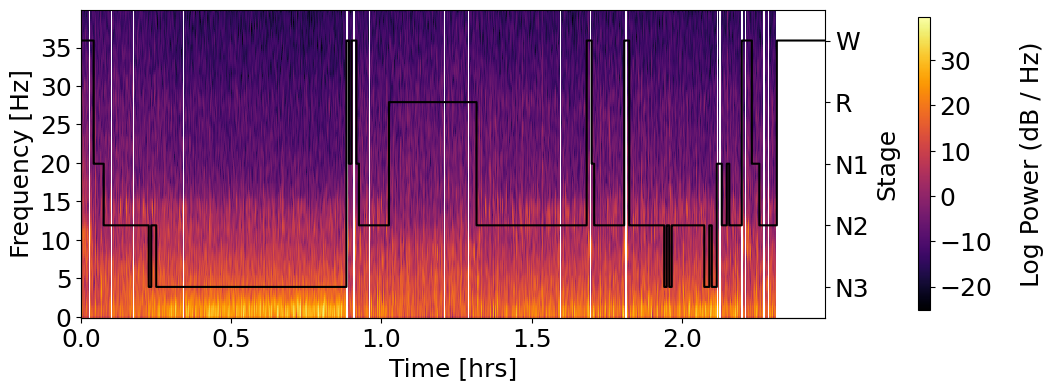

In [7]:
results_pipe.plot_hypnospectrogram(
    picks=['E101'],
    overlap=True)

Setting 192715 of 2229773 (8.64%) samples to NaN, retaining 2037058 (91.36%) samples.


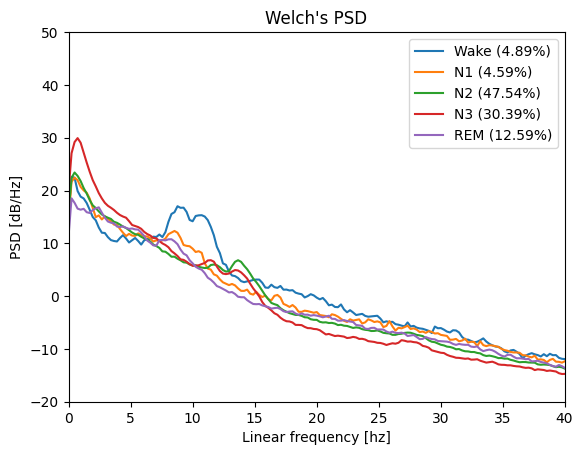

In [8]:
results_pipe.plot_psd_per_stage(
    picks=['E101'],
    psd_range=(-20, 50))

Create a collage with rows for sleep stages and columns for bands.

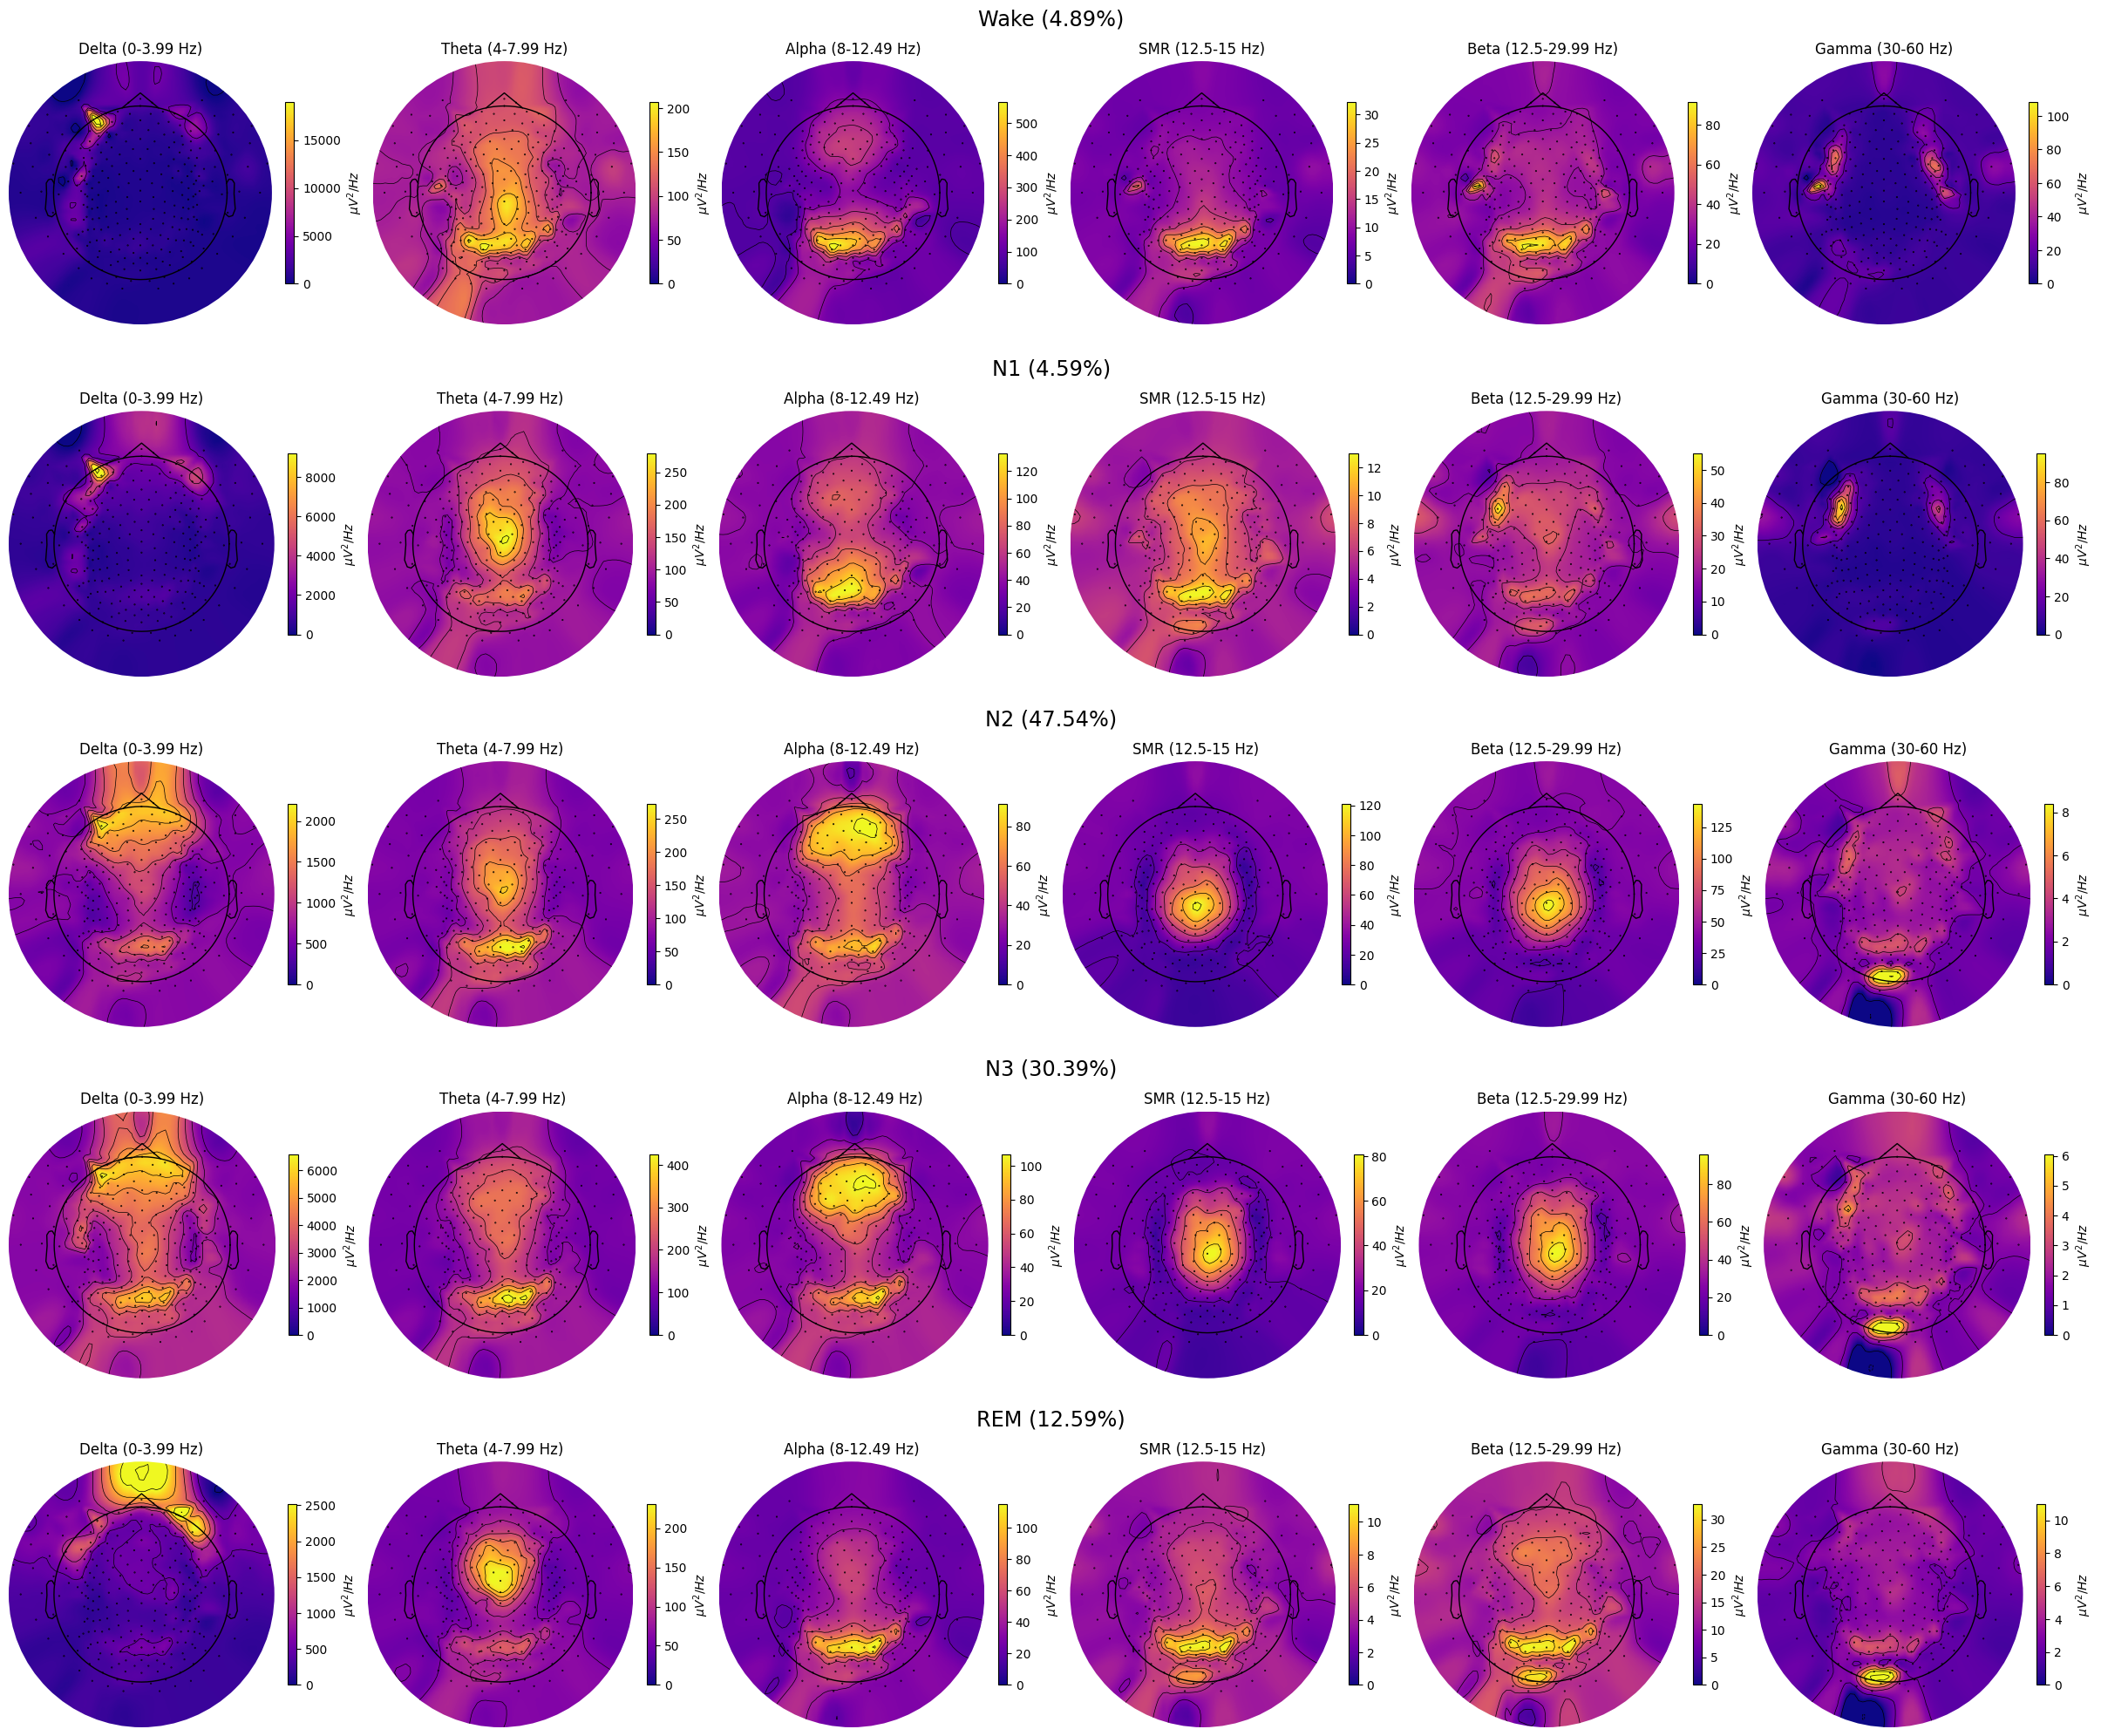

In [6]:
results_pipe.plot_topomap_collage()